In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

## Carregar e tratar a base

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # <-- Troca aqui
import joblib
import numpy as np


# Carregar os dados
data = np.load("/content/mimic_X_y_mask_10j.npz")
X = data['X']
y = data['y']
mask = data['mask']

# Balanceamento
idx_sepse = np.where(y == 1)[0]
idx_nsepse = np.where(y == 0)[0]
n = min(len(idx_sepse), len(idx_nsepse))
idx_balanced = np.concatenate([idx_sepse[:n], idx_nsepse[:n]])
np.random.shuffle(idx_balanced)

X_bal = X[idx_balanced]
y_bal = y[idx_balanced]
mask_bal = mask[idx_balanced]

# Divisão treino/val/teste
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(
    X_bal, y_bal, mask_bal, test_size=0.30, random_state=42, stratify=y_bal)

X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(
    X_temp, y_temp, mask_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Normalização segura por feature
def normalize_split_data(X_train, X_val, X_test):
    n_samples, n_janelas, n_features = X_train.shape
    X_train_norm = np.zeros_like(X_train)
    X_val_norm = np.zeros_like(X_val)
    X_test_norm = np.zeros_like(X_test)
    scalers = []

    for i in range(n_features):
        scaler = StandardScaler()  # <-- Troca aqui
        # scaler = MinMaxScaler()
        feat_train = X_train[:, :, i].reshape(-1, 1)
        scaler.fit(feat_train)  # Ajusta SOMENTE no treino

        # Aplica a mesma escala
        X_train_norm[:, :, i] = scaler.transform(feat_train).reshape(n_samples, n_janelas)
        X_val_norm[:, :, i] = scaler.transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], n_janelas)
        X_test_norm[:, :, i] = scaler.transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test.shape[0], n_janelas)

        scalers.append(scaler)

    return X_train_norm, X_val_norm, X_test_norm, scalers

# Executar normalização
X_train_norm, X_val_norm, X_test_norm, scalers = normalize_split_data(X_train, X_val, X_test)

# Salvar scalers
joblib.dump(scalers, "scalers_standard_lstm.pkl")  # <-- Nome atualizado

# Atualizar variáveis do pipeline
X_train, X_val, X_test = X_train_norm, X_val_norm, X_test_norm

print("✅ Normalização segura concluída com StandardScaler e scalers salvos!")


🔧 INICIANDO NOVA NORMALIZAÇÃO SEM LEAKAGE...
✅ Normalização segura concluída com StandardScaler e scalers salvos!


## Carregar sem tratar a base (V.1)

### Divisão dos dados em treino, validação e teste

- **Objetivo:** Separar o conjunto balanceado em três partes: treino (70%), validação (15%) e teste (15%).
- **Como:**
  - Primeiro, separa 70% para treino e 30% para validação+teste.
  - Depois, divide os 30% restantes igualmente entre validação e teste.
- **Estratificação:** A divisão mantém a proporção das classes (sepse/não sepse) em todos os conjuntos.
- **Importância:** Garante avaliação justa do modelo e evita vazamento de dados entre treino e teste.

### Construção do modelo LSTM

- **Definição da entrada:** O modelo recebe sequências no formato `(janelas, variáveis)` para cada paciente.
- **Máscara:** A camada `Masking` faz o modelo ignorar posições preenchidas com zero (usadas para padding).
- **LSTM:** Camada principal que processa as sequências temporais, capturando padrões ao longo do tempo.
- **Dropout:** Ajuda a evitar overfitting, desligando aleatoriamente parte dos neurônios durante o treino.
- **Dense:** Camada totalmente conectada para refinar a representação.
- **Saída:** Camada final com ativação sigmoide para prever a probabilidade de sepse (0 ou 1).

## LSTM

In [ ]:
# Definir a forma da entrada (janelas, variáveis)
input_shape = X_train.shape[1:]  # (10, 8)

# Construir o modelo
inputs = tf.keras.Input(shape=input_shape)
x = layers.Masking(mask_value=0.0)(inputs)
x = layers.LSTM(64, return_sequences=False)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_lstm = models.Model(inputs, outputs)

### Compilação do modelo LSTM

- **O que é feito:**  
  Esta célula configura como o modelo LSTM será treinado, definindo o otimizador, a função de perda e as métricas de avaliação.

- **Parâmetros definidos:**
  - **optimizer='adam':**  
    Utiliza o otimizador Adam, que é eficiente e amplamente usado em deep learning por ajustar automaticamente a taxa de aprendizado durante o treinamento.
  - **loss='binary_crossentropy':**  
    Define a função de perda como entropia cruzada binária, adequada para problemas de classificação binária (sepse ou não).
  - **metrics:**  
    Lista de métricas que serão monitoradas durante o treinamento e validação:
    - **BinaryAccuracy (accuracy):** Mede a proporção de previsões corretas (acertos) entre as amostras.
    - **AUC (Área sob a curva ROC):** Avalia a capacidade do modelo em distinguir entre as classes, considerando diferentes limiares de decisão.
    - **Recall (Sensibilidade):** Mede a proporção de casos positivos corretamente identificados (importante para não perder casos de sepse).
    - **Precision (Precisão):** Mede a proporção de previsões positivas que realmente são positivas (importante para evitar alarmes falsos).

- **Resumo:**  
  Com essa configuração, o modelo será treinado de forma eficiente e avaliado por métricas que ajudam a entender não só o acerto geral, mas também a capacidade de identificar corretamente casos de sepse e evitar falsos positivos.

In [ ]:
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)


### Treinamento do modelo LSTM

- **O que está sendo feito:**  
  Esta célula inicia o treinamento do modelo LSTM usando os dados de treino e validação.

- **Parâmetros principais:**
  - `X_train, y_train`: Dados de entrada e rótulos para o treinamento do modelo.
  - `validation_data=(X_val, y_val)`: Dados separados para validação, permitindo monitorar o desempenho do modelo em dados não vistos durante o treino.
  - `epochs=50`: O modelo será treinado por até 50 ciclos completos sobre o conjunto de treino. Um número maior de épocas pode ajudar o modelo a aprender melhor, mas também pode causar overfitting se exagerado.
  - `batch_size=64`: O modelo atualiza os pesos a cada 64 amostras. Batches maiores podem acelerar o treinamento, mas exigem mais memória.
  - `verbose=2`: Controla o nível de detalhamento dos logs durante o treinamento (2 mostra uma linha por época).

- **Por que usar validação?**  
  O conjunto de validação serve para acompanhar se o modelo está realmente aprendendo padrões úteis ou apenas decorando os dados de treino (overfitting). Assim, é possível ajustar hiperparâmetros e escolher o melhor modelo.

- **Resumo:**  
  Ao final desse processo, o histórico de treinamento (`history`) terá informações sobre a evolução das métricas de desempenho em treino e validação, permitindo avaliar e comparar os resultados.

In [ ]:
# Treinamento do modelo
history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=2
)

Epoch 1/50
147/147 - 7s - 47ms/step - accuracy: 0.6423 - auc: 0.7013 - loss: 0.6281 - precision: 0.6423 - recall: 0.6425 - val_accuracy: 0.6570 - val_auc: 0.7481 - val_loss: 0.6119 - val_precision: 0.6171 - val_recall: 0.8275
Epoch 2/50
147/147 - 4s - 31ms/step - accuracy: 0.6779 - auc: 0.7375 - loss: 0.6032 - precision: 0.6721 - recall: 0.6948 - val_accuracy: 0.6949 - val_auc: 0.7479 - val_loss: 0.5967 - val_precision: 0.7155 - val_recall: 0.6471
Epoch 3/50
147/147 - 3s - 18ms/step - accuracy: 0.6832 - auc: 0.7428 - loss: 0.5994 - precision: 0.6829 - recall: 0.6843 - val_accuracy: 0.6869 - val_auc: 0.7448 - val_loss: 0.6006 - val_precision: 0.6900 - val_recall: 0.6790
Epoch 4/50
147/147 - 2s - 11ms/step - accuracy: 0.6785 - auc: 0.7424 - loss: 0.5995 - precision: 0.6724 - recall: 0.6965 - val_accuracy: 0.6849 - val_auc: 0.7468 - val_loss: 0.6013 - val_precision: 0.7243 - val_recall: 0.5972
Epoch 5/50
147/147 - 2s - 12ms/step - accuracy: 0.6791 - auc: 0.7426 - loss: 0.5994 - precision:

In [ ]:
input_shape = X_train.shape[1:]  # alternativo

inputs = tf.keras.Input(shape=input_shape)
x = layers.Masking(mask_value=0.0)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_lstm = tf.keras.Model(inputs, outputs)
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

# Opcional: sample_weight por quantidade de janelas válidas
sample_weights = mask_train.sum(axis=1) / mask_train.shape[1]

# Treinamento
model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    sample_weight=sample_weights,
    verbose=2
)


Epoch 1/50
147/147 - 13s - 87ms/step - accuracy: 0.5748 - auc: 0.6207 - loss: 0.1359 - precision: 0.6045 - recall: 0.4331 - val_accuracy: 0.6680 - val_auc: 0.7166 - val_loss: 0.6402 - val_precision: 0.6495 - val_recall: 0.7298
Epoch 2/50
147/147 - 8s - 57ms/step - accuracy: 0.6579 - auc: 0.7102 - loss: 0.1277 - precision: 0.6680 - recall: 0.6279 - val_accuracy: 0.6974 - val_auc: 0.7452 - val_loss: 0.6098 - val_precision: 0.7297 - val_recall: 0.6271
Epoch 3/50
147/147 - 6s - 40ms/step - accuracy: 0.6698 - auc: 0.7276 - loss: 0.1243 - precision: 0.6687 - recall: 0.6730 - val_accuracy: 0.6994 - val_auc: 0.7534 - val_loss: 0.5957 - val_precision: 0.7123 - val_recall: 0.6690
Epoch 4/50
147/147 - 4s - 30ms/step - accuracy: 0.6753 - auc: 0.7368 - loss: 0.1222 - precision: 0.6741 - recall: 0.6790 - val_accuracy: 0.6834 - val_auc: 0.7556 - val_loss: 0.5927 - val_precision: 0.6578 - val_recall: 0.7647
Epoch 5/50
147/147 - 7s - 45ms/step - accuracy: 0.6788 - auc: 0.7409 - loss: 0.1213 - precision

### Predição e ajuste de limiar

- **Predição:**  
  O modelo LSTM gera, para cada amostra de teste, uma probabilidade (`y_pred_prob`) de ser positivo (ter sepse). Essas probabilidades são valores contínuos entre 0 e 1.

- **Ajuste de limiar:**  
  Para transformar as probabilidades em classes (0 ou 1), define-se um limiar (threshold), normalmente 0.5.  
  - Se a probabilidade for maior ou igual ao limiar, a previsão é positiva (1).
  - Se for menor, a previsão é negativa (0).

- **Importância:**  
  O ajuste do limiar pode ser alterado conforme a necessidade do problema, por exemplo, para aumentar o recall ou a precisão, dependendo do objetivo clinico


In [ ]:
# Definir a forma da entrada (janelas, variáveis)
input_shape = X_train.shape[1:]  # (10, 8)

# Construir o modelo aprimorado
inputs = tf.keras.Input(shape=input_shape)

# A camada Masking é ótima para dados faltantes ou preenchidos com zero
x = layers.Masking(mask_value=0.0)(inputs)

# Camada Bidirecional para capturar contexto de ambas as direções
# return_sequences=True é necessário para empilhar com outra camada recorrente
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x) # Aumentar um pouco o dropout para um modelo mais complexo

# Segunda camada LSTM para aprender padrões mais profundos
x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

# Camada densa para classificação final
x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x) # Dropout final antes da camada de saída

outputs = layers.Dense(1, activation='sigmoid')(x)

model_lstm = models.Model(inputs, outputs)

## Resultados

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Acurácia: 0.6891
AUC: 0.7417
Precisão: 0.6905
Revocação: 0.6849
F1-score: 0.6877


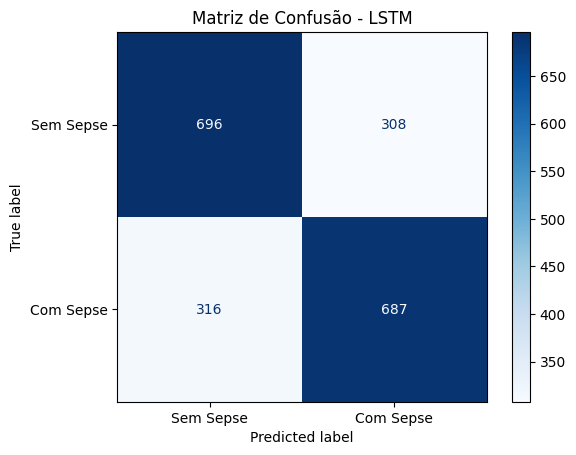

In [ ]:
# Predição
y_pred_prob = model_lstm.predict(X_test).flatten()

# Ajustar limiar (exemplo: 0.5)
limiar = 0.5
y_pred = (y_pred_prob >= limiar).astype(int)

# Métricas
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Revocação: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sem Sepse", "Com Sepse"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - LSTM")
plt.show()

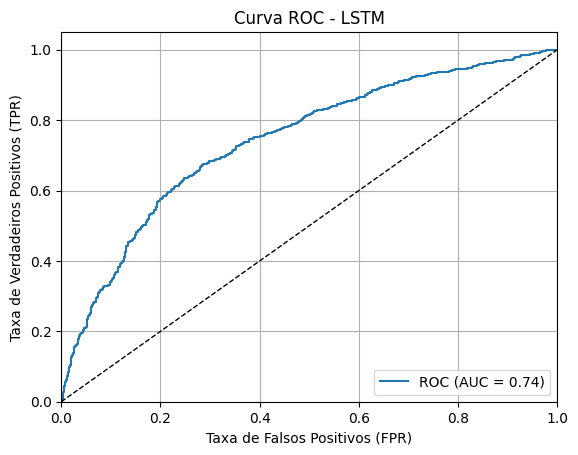

In [ ]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - LSTM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

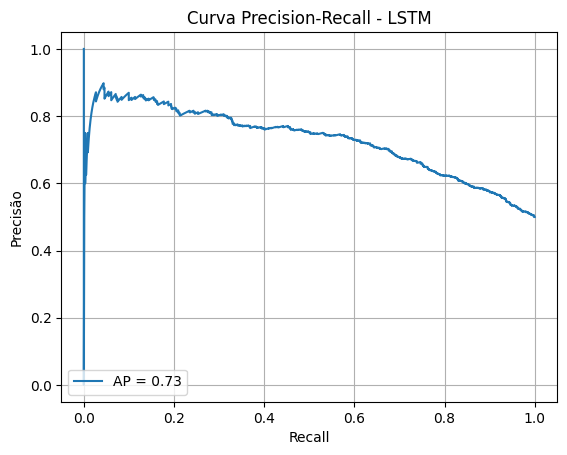

In [ ]:
# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)

plt.figure()
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall - LSTM")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()